In [1]:
# Create cutouts and sigma maps for COSMOS dataset

In [2]:
# https://github.com/Grillard/GalfitPyWrap may be useful for setting up inputs
import sys
sys.path.insert(0,'/data/emiln/XLSSU122/analysis/galfit/GalfitPyWrap')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
from __future__ import division
import fnmatch
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/emiln/anaconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
# Load cosmos catalog
cos_cat = '/data/emiln/XLSSU122/analysis/allfields_candels/vdwel/Downloads/cos_2epoch_wfc3_f125w_060mas_v1.0_galfit.cat'
cos_df = pd.read_csv(cos_cat,header=0,delim_whitespace=True,skiprows=[1])
cos_df2 = cos_df[cos_df.columns[:-1]]
cos_df2.columns = cos_df.columns[1:]
cos_df = cos_df2
print len(cos_df)
cos_df = cos_df[(cos_df['mag']<23) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now
cos_df = cos_df[(cos_df['mag']<21) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now
cos_df = cos_df[(cos_df['dn']/cos_df['n'])<1] # Filter out objects with > 100% error
# f=0 are all "good fits" https://users.ugent.be/~avdrwel/data/readme_candels.txt
print len(cos_df)
cos_df.columns.values

38671
838


array(['NUMBER', 'RA', 'DEC', 'f', 'mag', 'dmag', 're', 'dre', 'n', 'dn',
       'q', 'dq', 'pa', 'dpa', 'sn'], dtype=object)

In [9]:
cos_df_highz_all = pd.read_csv('cos_z2_thresh0p1_all.csv')

In [10]:
print len(cos_df_highz_all)

260


In [3]:
cos_df

,NUMBER,RA,DEC,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn
346,347,150.125061,2.182366,0,18.6633,0.003298,0.019338,0.000110,2.1110,0.028812,0.4505,0.004980,-74.1111,0.632949,901.276
433,434,150.115204,2.182847,0,17.4897,0.001186,0.030696,0.000059,0.6546,0.002993,0.4493,0.001704,-57.7747,0.191815,2299.65
542,543,150.083038,2.186648,0,20.7930,0.010390,0.704964,0.008189,1.8183,0.037570,0.3058,0.005552,87.9874,0.430939,299.806
543,544,150.130371,2.185945,0,20.2375,0.004955,0.571914,0.002996,1.3950,0.014848,0.3561,0.002878,84.6609,0.230404,590.901
560,561,150.079315,2.185860,0,20.5360,0.009509,0.636768,0.007032,2.0473,0.040846,0.8388,0.005346,-72.7879,0.429146,328.294
802,803,150.119278,2.187906,0,20.6560,0.010884,0.776682,0.008842,1.3614,0.028495,0.8450,0.005745,-3.2507,0.422511,281.777
835,836,150.151749,2.188684,0,20.4047,0.007829,0.633228,0.004848,1.1709,0.018925,0.7852,0.004424,25.1856,0.326563,372.271
855,856,150.073822,2.189355,0,20.8182,0.011331,0.381882,0.006999,5.3467,0.173397,0.7926,0.010616,-78.4965,1.242330,312.358
885,886,150.118835,2.189954,0,20.4608,0.007090,0.275172,0.003144,3.0431,0.068567,0.3509,0.007989,-62.9356,0.867721,463.785
909,910,150.158203,2.190113,0,20.6287,0.009025,0.648060,0.005577,1.0386,0.019273,0.7468,0.005098,-70.1169,0.364658,320.536


--------------

### Modify PSF

In [7]:
# Subsample PSF, resample to 0.06'' pixel scale, apply diffusion kernel, combine PSFs at each dither
# position with same params as mosaic

In [8]:
from scipy.ndimage.filters import gaussian_filter as gaussf
from matplotlib.colors import LogNorm

1.0000001
1.0000001
0.0


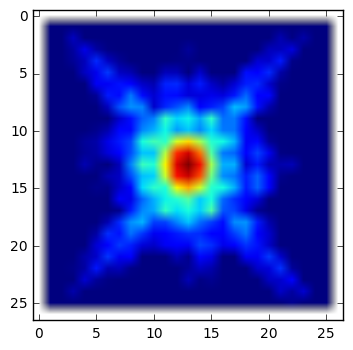

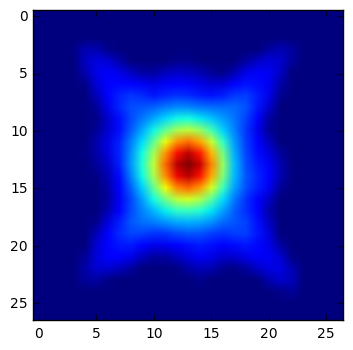

In [9]:
# Boost TT
orig_psf = '/data/emiln/XLSSU122/analysis/cosmos/tinytim_psf.fits'
psf_hdu = fits.open(orig_psf)
psf_data = psf_hdu[0].data
print np.sum(psf_data) # Original PSF integrates to 1
psf_smoothed = gaussf(psf_data,1)
print np.sum(psf_smoothed)
print np.min(psf_data)
# plt.imshow(psf_data,vmin=0,vmax=0.1)
plt.imshow(psf_data,norm=LogNorm(vmin=1e-4,vmax=1e-1))
plt.show()
plt.imshow(psf_smoothed,norm=LogNorm(vmin=1e-4,vmax=1e-1))
plt.show()
# plt.imshow(psf_data,vmin=0,vmax=0.1)


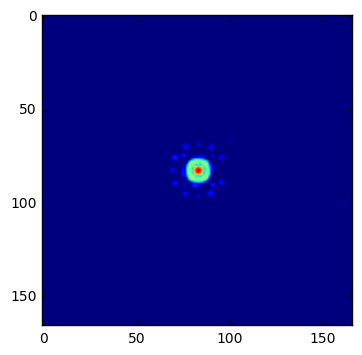

In [10]:
# Resample to 0.06 
orig_psf = '/data/emiln/XLSSU122/analysis/cosmos/f125w_400_400_6arcsec_psf.fits' # Pixel scale = 0.036 ''/pix
psf_hdu = fits.open(orig_psf)
psf_data = psf_hdu[0].data
plt.imshow(psf_data,norm=LogNorm(vmin=1e-4,vmax=1e-1))
plt.show()

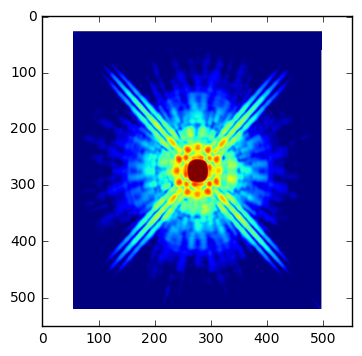

In [22]:
# Resample to 0.06 
orig_psf = '/data/emiln/XLSSU122/analysis/tinytim/test/SUBSAMPLED_PSF00.fits' # Pixel scale = 0.013 ''/pix
psf_hdu = fits.open(orig_psf)
psf_data = psf_hdu[0].data
plt.imshow(psf_data,norm=LogNorm(vmin=1e-7,vmax=1e-4))
plt.show()

In [23]:
import glob
import os
import shutil

from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle
from IPython.display import Image
import matplotlib.pyplot as plt

ImportError: No module named astroquery.mast

----------

### Make source cutouts

In [6]:
# Load cosmos fits images

cos_file = '/data/emiln/XLSSU122/analysis/cosmos/hlsp_candels_hst_wfc3_cos-tot_f125w_v1.0_drz.fits'
cos_exp_file = '/data/emiln/XLSSU122/analysis/cosmos/hlsp_candels_hst_wfc3_cos-tot_f125w_v1.0_exp.fits'
cos_rms_file = '/data/emiln/XLSSU122/analysis/cosmos/hlsp_candels_hst_wfc3_cos-tot_f125w_v1.0_rms.fits'
cos_wht_file = '/data/emiln/XLSSU122/analysis/cosmos/hlsp_candels_hst_wfc3_cos-tot_f125w_v1.0_wht.fits'
cos_hdulist = fits.open(cos_file)
full_wcs = wcs.WCS(cos_hdulist[0].header)

exp_hdulist = fits.open(cos_exp_file)
rms_hdulist = fits.open(cos_rms_file)
wht_hdulist = fits.open(cos_wht_file)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [7]:
print len(cos_df)

838


In [6]:
df = cos_df[cos_df['NUMBER']==886]

In [8]:
cos_df_highz_all.columns.values

array(['ID', 'IAU_designation', 'RA_x', 'DEC_x', 'APCOR', 'CFHT_uS_FLUX',
       'CFHT_uS_FLUXERR', 'CFHT_gS_FLUX', 'CFHT_gS_FLUXERR',
       'CFHT_rS_FLUX', 'CFHT_rS_FLUXERR', 'CFHT_iS_FLUX',
       'CFHT_iS_FLUXERR', 'CFHT_zS_FLUX', 'CFHT_zS_FLUXERR',
       'Subaru_B_FLUX', 'Subaru_B_FLUXERR', 'Subaru_gp_FLUX',
       'Subaru_gp_FLUXERR', 'Subaru_V_FLUX', 'Subaru_V_FLUXERR',
       'Subaru_rp_FLUX', 'Subaru_rp_FLUXERR', 'Subaru_ip_FLUX',
       'Subaru_ip_FLUXERR', 'Subaru_zp_FLUX', 'Subaru_zp_FLUXERR',
       'ACS_F606W_FLUX', 'ACS_F606W_FLUXERR', 'ACS_F814W_FLUX',
       'ACS_F814W_FLUXERR', 'WFC3_F125W_FLUX', 'WFC3_F125W_FLUXERR',
       'WFC3_F160W_FLUX', 'WFC3_F160W_FLUXERR', 'UltraVISTA_Y_FLUX',
       'UltraVISTA_Y_FLUXERR', 'UltraVISTA_J_FLUX',
       'UltraVISTA_J_FLUXERR', 'UltraVISTA_H_FLUX',
       'UltraVISTA_H_FLUXERR', 'UltraVISTA_Ks_FLUX',
       'UltraVISTA_Ks_FLUXERR', 'IRAC_Ch1_FLUX', 'IRAC_Ch1_FLUXERR',
       'IRAC_Ch2_FLUX', 'IRAC_Ch2_FLUXERR', 'IRAC_Ch3_FLUX',

(array([112.,  85.,  45.,  13.,   2.,   2.,   0.,   0.,   0.,   1.]),
 array([ 1.364 ,  2.7872,  4.2104,  5.6336,  7.0568,  8.48  ,  9.9032,
        11.3264, 12.7496, 14.1728, 15.596 ]),
 <a list of 10 Patch objects>)

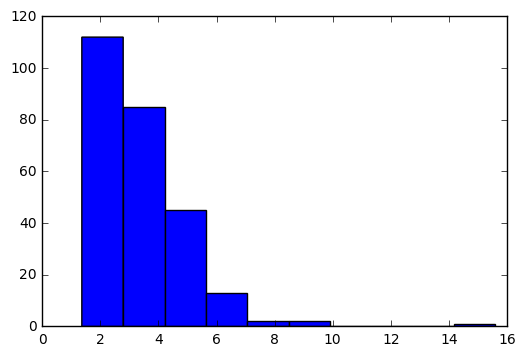

In [26]:
plt.hist(cos_df_highz_all['FLUX_RADIUS_1_F125W'])

In [28]:
# For each object in cos_df
# Make a directory to store data products
# Create image cutout with same header and updated wcs info
# Create cutout sigma image in units of cps

import copy

exptime=1900 # https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf
w=400
# df = cos_df[cos_df['NUMBER']==886]
# df = cos_df[0:2]
# df = cos_df
df = cos_df_highz_all

# df = cos_df
for idx, r in df.iterrows():
    ra = r.RA
    dec = r.DEC
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    ID = int(r['NUMBER'])
    
    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    
    tdir = '/data/emiln/XLSSU122/analysis/cosmos/galfit_results/'+str(ID)
    try:
        os.mkdir(tdir)
    except:
        print("Directory already exists.")

    wmapcut = full_wcs[Y-w:Y+w,X-w:X+w]
    datacut = cos_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    expcut = exp_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    rmscut = rms_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    whtcut = wht_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    print expcut.shape
    print datacut.shape
    print rmscut.shape
    print whtcut.shape

    newdata = datacut # this is in ELECTRONS/s
    newexp = expcut
    newrms = rmscut # this is in ELECTRONS/s
    newwht = whtcut
    newcounts = newdata * expcut 
    newcounts2 = newdata * expcut / 2.5 # Should divide by the gain = 2.5 (e/count) to get this in counts
    
    central_mask = np.zeros(newdata.shape)
    xx, yy = np.meshgrid(np.arange(central_mask.shape[0]),np.arange(central_mask.shape[1]))
    xc = newdata.shape[0]/2
    yc = newdata.shape[1]/2
    rthresh = r.FLUX_RADIUS_1_F125W # Mask out inner 20% light radius
    central_mask_IDs = (xx-xc)**2+(yy-yc)**2 < rthresh**2
    central_mask[central_mask_IDs] = 1
    
    nonzero_counts = newcounts.copy()
    nonzero_counts[nonzero_counts<0] = 0
    
    nonzero_counts2 = newcounts2.copy()
    nonzero_counts2[nonzero_counts2<0] = 0
    
    newcounts_meanexp = newdata * np.mean(expcut)
    nonzero_counts_meanexp = newcounts_meanexp.copy()
    nonzero_counts_meanexp[nonzero_counts_meanexp<0] = 0
    print np.min(nonzero_counts)
    
    newcounts_meanexp2 = newdata * np.mean(expcut) / 2.5
    nonzero_counts_meanexp2 = newcounts_meanexp2.copy()
    nonzero_counts_meanexp2[nonzero_counts_meanexp2<0] = 0
    
#     newsigma = (np.sqrt(1./rmscut) + np.sqrt(nonzero_counts))/expcut
#     newsigma_meanexp = (np.sqrt(1./rmscut) + np.sqrt(nonzero_counts_meanexp))/np.mean(expcut)
#     newsigma_counts = np.sqrt(rmscut * np.mean(expcut)) / 2.5 + np.sqrt(nonzero_counts_meanexp2)
    
    # RMS + POISSON
    newsigma_rms_meanexp = rmscut + np.sqrt(nonzero_counts_meanexp)/np.mean(expcut)
#     newsigma_counts = np.sqrt(rmscut * np.mean(expcut)) / 2.5 + np.sqrt(nonzero_counts_meanexp2)
    
#     newsigma = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts))/expcut
#     newsigma_meanexp = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts_meanexp))/np.mean(expcut)
#     newsigma_counts = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts)) / 2.5

    
#     new_cos_hdu = fits.PrimaryHDU(newdata)
#     new_cos_hdul = fits.HDUList([new_cos_hdu])
#     new_cos_hdul[0].header = cos_hdulist[0].header
#     new_cos_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_cos_filename = tdir+'/cutout.fits'
#     new_cos_hdul.writeto(new_cos_filename, clobber=True)

##### Oct 10 ####

    new_cos_hdu = fits.PrimaryHDU(newdata)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = cos_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/data_cps.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)
    
    new_cos_hdu = fits.PrimaryHDU(central_mask)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = cos_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/20p_mask.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)

    new_sigma_hdu = fits.PrimaryHDU(newsigma_rms_meanexp)
    new_sigma_hdul = fits.HDUList([new_sigma_hdu])
    new_sigma_hdul[0].header = copy.deepcopy(rms_hdulist[0].header)
    new_sigma_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
    new_sigma_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_sigma_filename = tdir+'/sigma_rms_meanexp_cps.fits'
    new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

####################
    
#     new_sigma_hdu = fits.PrimaryHDU(newsigma_counts)
#     new_sigma_hdul = fits.HDUList([new_sigma_hdu])
#     new_sigma_hdul[0].header = copy.deepcopy(rms_hdulist[0].header)
#     new_sigma_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_filename = tdir+'/sigma_meanexp_counts.fits'
#     new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

#     new_sigma_hdu3 = fits.PrimaryHDU(newsigma_counts)
#     new_sigma_hdul3 = fits.HDUList([new_sigma_hdu3])
#     new_sigma_hdul3[0].header = copy.deepcopy(rms_hdulist[0].header)
#     new_sigma_hdul3[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_hdul3[0].header['EXPTIME'] = exptime
#     new_sigma_filename = tdir+'/sigma_meanexp_counts_ADU_exp_adjusted.fits'
#     new_sigma_hdul3.writeto(new_sigma_filename, clobber=True)
    
#     new_sigma_hdu = fits.PrimaryHDU(nonzero_counts_meanexp2)
#     new_sigma_hdul = fits.HDUList([new_sigma_hdu])
#     new_sigma_hdul[0].header = copy.deepcopy(rms_hdulist[0].header)
#     new_sigma_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_filename = tdir+'/counts_cutout_meanexp_ADU.fits'
#     new_sigma_hdul.writeto(new_sigma_filename, clobber=True)
    
#     new_sigma_hdu2 = fits.PrimaryHDU(nonzero_counts_meanexp2)
#     new_sigma_hdul2 = fits.HDUList([new_sigma_hdu2])
#     new_sigma_hdul2[0].header = copy.deepcopy(rms_hdulist[0].header)
#     new_sigma_hdul2[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_hdul2[0].header['EXPTIME'] = exptime
#     new_sigma_filename = tdir+'/counts_cutout_meanexp_ADU_exp_adjusted.fits'
#     new_sigma_hdul2.writeto(new_sigma_filename, clobber=True)


#     new_sigma_hdu = fits.PrimaryHDU(newsigma)
#     new_sigma_hdul = fits.HDUList([new_sigma_hdu])
#     new_sigma_hdul[0].header = rms_hdulist[0].header
#     new_sigma_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_filename = tdir+'/wht_sigma_cutout.fits'
#     new_sigma_hdul.writeto(new_sigma_filename, clobber=True)
    
#     new_sigma_meanexp_hdu = fits.PrimaryHDU(newsigma_meanexp)
#     new_sigma_meanexp_hdul = fits.HDUList([new_sigma_meanexp_hdu])
#     new_sigma_meanexp_hdul[0].header = rms_hdulist[0].header
#     new_sigma_meanexp_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_meanexp_filename = tdir+'/wht_sigma_meanexp_cutout.fits'
#     new_sigma_meanexp_hdul.writeto(new_sigma_meanexp_filename, clobber=True)
    
#     new_counts_hdu = fits.PrimaryHDU(newcounts)
#     new_counts_hdul = fits.HDUList([new_counts_hdu])
#     new_counts_hdul[0].header = cos_hdulist[0].header
#     new_counts_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_counts_filename = tdir+'/counts_cutout.fits'
#     new_counts_hdul.writeto(new_counts_filename, clobber=True)
    
#     new_counts_meanexp_hdu = fits.PrimaryHDU(newcounts_meanexp)
#     new_counts_meanexp_hdul = fits.HDUList([new_counts_meanexp_hdu])
#     new_counts_meanexp_hdul[0].header = cos_hdulist[0].header
#     new_counts_meanexp_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_counts_meanexp_filename = tdir+'/counts_meanexp_cutout.fits'
#     new_counts_meanexp_hdul.writeto(new_counts_meanexp_filename, clobber=True)
    
#     new_exp_hdu = fits.PrimaryHDU(newexp)
#     new_exp_hdul = fits.HDUList([new_exp_hdu])
#     new_exp_hdul[0].header = exp_hdulist[0].header
#     new_exp_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_exp_filename = tdir+'/exp_cutout.fits'
#     new_exp_hdul.writeto(new_exp_filename, clobber=True)
    
#     new_rms_hdu = fits.PrimaryHDU(newrms)
#     new_rms_hdul = fits.HDUList([new_rms_hdu])
#     new_rms_hdul[0].header = rms_hdulist[0].header
#     new_rms_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_rms_filename = tdir+'/rms_cutout.fits'
#     new_rms_hdul.writeto(new_rms_filename, clobber=True)

[array(8236.4986977), array(7912.15424593)]
ID 125
RA: 150.1023779
DEC: 2.1795006
Initial X: 8236
Initial Y: 7912
Directory already exists.
(800, 800)
(800, 800)
(800, 800)
(800, 800)
0.0
INFO: 
        Inconsistent SIP distortion information is present in the current WCS:
        SIP coefficients were detected, but CTYPE is missing "-SIP" suffix,
        therefore the current WCS is internally inconsistent.

        Because relax has been set to True, the resulting output WCS will have
        "-SIP" appended to CTYPE in order to make the header internally consistent.

        However, this may produce incorrect astrometry in the output WCS, if
        in fact the current WCS is already distortion-corrected.

        Therefore, if current WCS is already distortion-corrected (eg, drizzled)
        then SIP distortion components should not apply. In that case, for a WCS
        that is already distortion-corrected, please remove the SIP coefficients
        from the header.

         [a

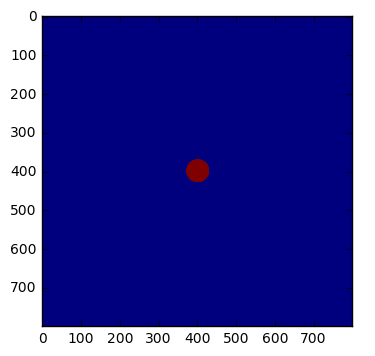

In [25]:
central_mask = np.zeros(newdata.shape)
xx, yy = np.meshgrid(np.arange(central_mask.shape[0]),np.arange(central_mask.shape[1]))
xc = newdata.shape[0]/2
yc = newdata.shape[1]/2
r = 30
central_mask_IDs = (xx-xc)**2+(yy-yc)**2 < r**2
plt.imshow(central_mask_IDs)